# DS-GA 3001.001 Special Topics in Data Science: Probabilistic Time Series Analysis

# Gaussian Processes

$$GP(\mu(x), K(x_1, x_2))$$

mean usually to $\mu(x)=0$

structure defined through covariance $K(x_1, x_2)$

In [48]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
import time
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel, ExpSineSquared
np.random.seed(12)

Visualization functions

In [49]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None, ax=None, legendon=True):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        ax.plot(x_pred.reshape(-1, 1), samples)
    
    ax.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
                 label="pred mean")
    ax.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        ax.plot(x_pred, true_y, "b-", label="ground truth")
    if legendon: ax.legend()
    
def predict(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, cholesky=True, beta_inv = 0):
    """
    Top level wrapper function for GP prediction
    """
    if cholesky:
        return predict_cholesky(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv)
    else:
        return predict_inverse(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv)

def predict_inverse(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    C = kernel(X_train, X_train, scal, par_SE, par_lin, par_pol) + np.eye(len(X_train))*beta_inv
    B = kernel(x_pred, X_train, scal, par_SE, par_lin, par_pol)
    C_inv = np.linalg.inv(C)
    A = kernel(x_pred, x_pred, scal, par_SE, par_lin, par_pol) + np.eye(len(x_pred))*beta_inv
    mu = np.dot(B, C_inv).dot(y_train)
    cov = A - np.dot(B, C_inv).dot(B.T)    
    return mu, cov

def predict_cholesky(x_pred, X_train, y_train, kernel, scal, par_SE, par_pol, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    ############################################
    ### TODO: please implement this function ###
    ############################################
    A = kernel(x_pred, x_pred, scal, par_SE, par_pol) + np.eye(len(x_pred))*beta_inv
    C = kernel(X_train, X_train, scal, par_SE, par_pol) + np.eye(len(X_train))*beta_inv
    B = kernel(x_pred, X_train, scal, par_SE, par_pol)
    L = np.linalg.cholesky(C)
    inv1 = np.linalg.solve(L, B.T)
    inv2 = np.linalg.solve(L, y_train)
    mu = inv1.T.dot(inv2)
    cov = A-inv1.T.dot(inv1)
    return mu, cov

def sample_cholesky(mu, cov, n_points, n_samples):
    """
    Function that performs sampling from multi-variate Gaussian using Cholesky Decomposition
    @param mu: a numpy array of size n
    @param cov: a numpy matrix of size n*n
    @param n_points: how many points per sample
    @param n_samples: how many samples
    @return a numpy matrix with dimension (n_points, n_samples)
    """
    ############################################
    ### TODO: please implement this function ###
    ############################################
    L = np.linalg.cholesky(cov)
    z = np.random.randn(n_points, n_samples)
    x = ((z.T.dot(L))+mu)
    return x.T

Various generative functions for GP to approximate.

Generate train and test data.

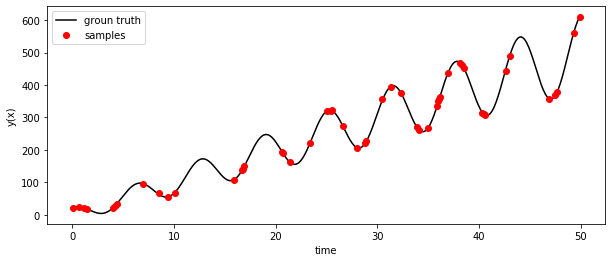

In [50]:
n_train = 50
beta_inv = 2

def gen_y(time, a=10, b=0, w=1, c=2, d=20):
    return a*time+b+np.cos(w*time)*(c*time+d)

# X2: time
time = np.arange(0,50,.1)
# Y2: this is the true values of f(x) for x in (x_min, x_max)
# (we are NOT using them to train GP. true_y is only used for evaluation)
true_y = gen_y(time)
plt.figure(figsize=(10,4))
plt.fill_between(time, true_y - np.sqrt(beta_inv),
                true_y + np.sqrt(beta_inv), alpha=.4)
plt.plot(time, true_y, '-k', label='groun truth') #  + np.random.randn(len(time))*R


# X1, Y1: a randomly given training set of: n_train training points

tsamp = np.random.choice(time, n_train, replace=False)
# noisy data points
y_train = gen_y(tsamp)+ np.random.randn(len(tsamp))*beta_inv

np.random.seed(0)
plt.plot(tsamp, y_train, 'or', label='samples')
plt.xlabel('time')
plt.ylabel('y(x)')
plt.legend()

## kernels
(helpful to read Bishop 6.2. Constructing Kernels)

In [51]:
def K_SE(x, y, params):
    """
    Function that implements the squared exponential kernel
    """
    sigma, l = params
    return np.power(sigma,2) * np.exp( - np.subtract.outer(x, y)**2/(2 * np.power(l,2)))

def K_linear(x,y):
    return np.outer(x,y)

def K_poly(x,y,params):
    return (np.outer(x,y))**params 


def K_cos(x,y):
    return np.cos(1e-4*(np.array([x]).T-np.array([y]))**2) 

Text(0, 0.5, 'time')

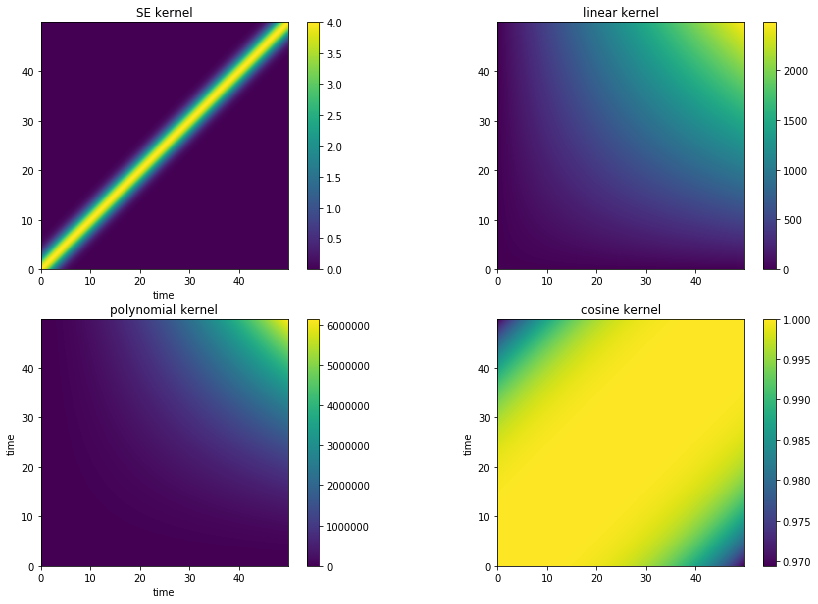

In [52]:
par_SE=(2,2)
par_pol=2

fig, ax = plt.subplots(2,2, figsize=(15,10))
im = ax[0,0].pcolor(time, time, K_SE(time, time, par_SE))
ax[0,0].set_aspect(1)
fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('SE kernel')
ax[0,0].set_xlabel('time')

im = ax[0,1].pcolor(time, time, K_linear(time, time))
ax[0,1].set_aspect(1)
fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('linear kernel')

im = ax[1,0].pcolor(time, time, K_poly(time, time, par_pol))
ax[1,0].set_aspect(1)
fig.colorbar(im, ax=ax[1,0])
ax[1,0].set_title('polynomial kernel')
ax[1,0].set_xlabel('time')
ax[1,0].set_ylabel('time')

im = ax[1,1].pcolor(time, time, K_cos(time, time))
ax[1,1].set_aspect(1)
fig.colorbar(im, ax=ax[1,1])
ax[1,1].set_title('cosine kernel')
ax[1,1].set_ylabel('time')

## estimation/prediction

With 20 points

rmse = 54.07146957368321
rmse = 47.645022430431794
rmse = 92.46297129078495
rmse = 74.345101948404


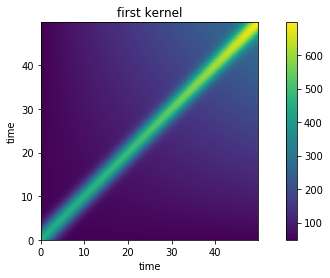

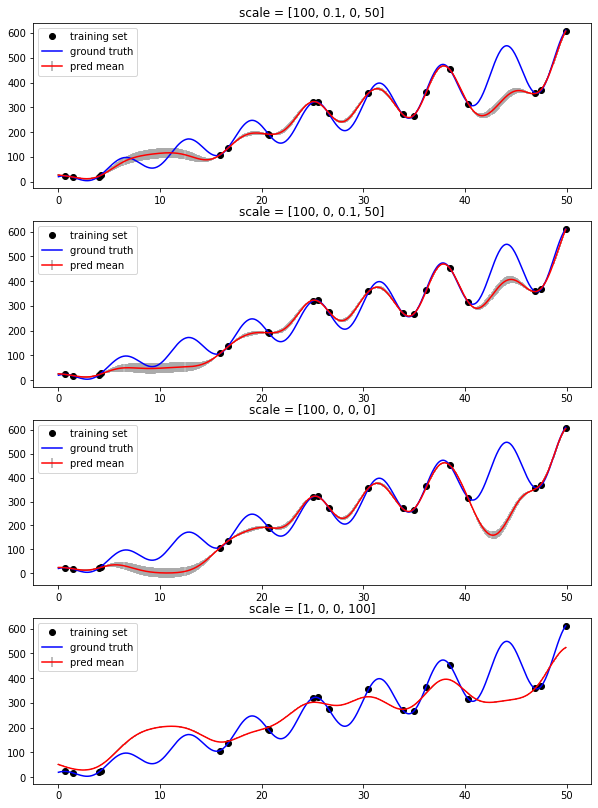

In [53]:
def kernel(x, y, scal, par_SE, par_pol):
    return scal[0]*K_SE(x, y, par_SE) +scal[1]*K_linear(x, y) + \
            scal[2]*K_poly(x, y, par_pol) + scal[3]*K_cos(x, y)

training_data_num = 20
cholesky = True

# take a linear weighted sum of the kernels, weights defined by scalar:
SCAL = [[100, .1, 0, 50],
        [100, 0, .1, 50],
        [100, 0, 0, 0],
        [1, 0, 0, 100]]


need_X_train = tsamp[:training_data_num]
need_y_train = y_train[:training_data_num]

plt.figure(figsize=(10,4))
plt.pcolor(time, time, kernel(time, time, SCAL[0], par_SE, par_pol))
plt.axis('square')
plt.colorbar()
plt.title('first kernel')
plt.xlabel('time')
plt.ylabel('time')

fig, ax = plt.subplots(len(SCAL), 1, figsize=(10,14))
for ss in range(len(SCAL)):
    mus, cov = predict(time, tsamp[:training_data_num], y_train[:training_data_num], kernel, 
                       SCAL[ss], par_SE, par_pol, cholesky=cholesky, beta_inv=beta_inv)
    sigmas = np.sqrt(np.diag(cov))
    plot_gp(time, mus, sigmas, need_X_train, need_y_train, true_y, ax=ax[ss])
    print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))
    ax[ss].set_title('scale = '+np.str(SCAL[ss]))

## sampling

Sample from posterior with 30 points

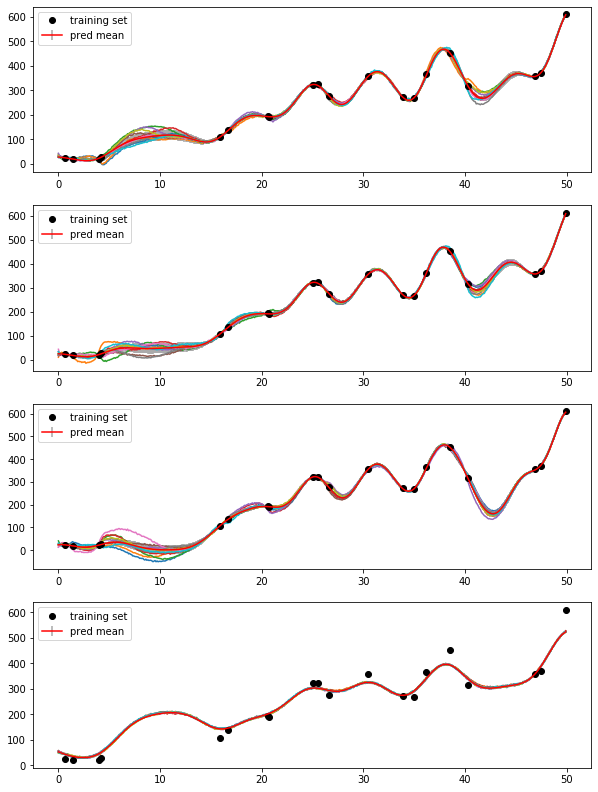

In [54]:
n_samples = 10


fig, ax = plt.subplots(len(SCAL), 1, figsize=(10,14))
for ss in range(len(SCAL)):
    mus, cov = predict(time, tsamp[:training_data_num], y_train[:training_data_num], kernel, 
                       SCAL[ss], par_SE, par_pol, cholesky=cholesky, beta_inv=beta_inv)

    sigmas = np.sqrt(np.diag(cov))

    # sampling - using sample_cholesky
    samples = sample_cholesky(mus, cov, len(time), n_samples)

    # plot samples
    plot_gp(time, mus, sigmas, tsamp[:training_data_num], y_train[:training_data_num], samples=samples, ax=ax[ss])

## forecasting

rmse = 124.06157231804079
rmse = 152.85366218026167
rmse = 315.6473888647486
rmse = 88.87963971772825


C:\Users\colin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


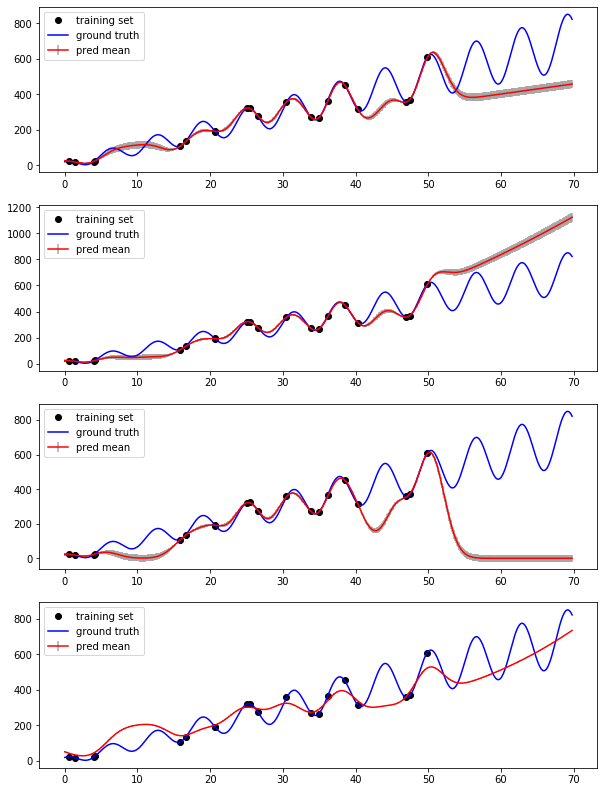

In [55]:
predtime = np.arange(0,np.max(time)+20,.1)
pred_y = gen_y(predtime)

fig, ax = plt.subplots(len(SCAL), 1, figsize=(10,14))
for ss in range(len(SCAL)):
    mus, cov = predict(predtime, tsamp[:training_data_num], y_train[:training_data_num], kernel, 
                       SCAL[ss], par_SE, par_pol, cholesky=cholesky, beta_inv=beta_inv)

    sigmas = np.sqrt(np.diag(cov))

    plot_gp(predtime, mus, sigmas, need_X_train, need_y_train, pred_y, ax=ax[ss])
    print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, pred_y))))

## Improving forecasting

TODO:
Using the scikit-learn API, fit a GP with better forecasting

Hint: Use a better kernel!

Plot the forecasting performance of the newly fit kernel.


In [1]:
# TODO: Fit a Gaussian Process using your selected kernel, and show its improved forecasting performance

## Demonstrating necessity
TODO:
Prove that each element of your kernel is necessary by showing that forecasting fails when each element is removed.

TODO:
Write a short description of why each component is important.

In [2]:
# TODO: Remove each element from your selected kernel, refit, and show its reduced forecasting performance

### Please turn in the code before 11/24/2020 at 11:59 pm. Please name your notebook netid.ipynb.

### Your work will be evaluated based on the code, plots, AND question answers (this is NEW!). 